In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow.keras.datasets as tfds
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B1
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [2]:
#Start module from here

In [3]:
#this part is only due to cyrillic characters issue in folder names reading on my mashine
detail_names_list = ['CS120.01.413', 'CS120.07.442', 'CS150.01.427-01', 'SU160.00.404', 'SU80.01.426', 'SU80.10.409A', 'ЗВТ86.103К-02',
 'СВМ.37.060', 'СВМ.37.060А', 'СВП-120.00.060', 'СВП120.42.020', 'СВП120.42.030', 'СК20.01.01.01.406',
 'СК20.01.01.02.402', 'СК30.01.01.02.402', 'СК30.01.01.03.403', 'СК50.01.01.404', 'СК50.02.01.411', 'СПО250.14.190']

In [23]:
import os
path = os.getcwd()
data_dir = path +'\\dataset'
#os.scandir
#from glob import glob
#glob('C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\*', recursive = True)

['C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\01',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\02',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\03',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\04',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\05',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\06',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\07',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\08',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\09',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\10',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\11',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\12',
 'C:\\Users\\Gli

In [24]:
batch_size = 32
img_height = 300
img_width = 300

train_ds1 = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=True,
  batch_size=batch_size)

Found 1541 files belonging to 19 classes.
Using 1233 files for training.


In [25]:
val_ds1 = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1541 files belonging to 19 classes.
Using 308 files for validation.


In [27]:
class_names = train_ds1.class_names
print(class_names)


['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


In [28]:
num_classes = len(class_names)

In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds1 = train_ds1.cache().prefetch(buffer_size=AUTOTUNE)
val_ds1 = val_ds1.cache().prefetch(buffer_size=AUTOTUNE)

In [33]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    start_from_epoch=10,
    patience=4
)
model_save = tf.keras.callbacks.ModelCheckpoint(
    path,
    save_best_only = True,
)
callbacks = [early_stop,model_save]

In [34]:
epochs = 40

# create the base pre-trained model
base_model = EfficientNetV2B1(weights='imagenet', include_top=False, input_shape = (img_height, img_width, 3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True
  metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(
    train_ds1,
    validation_data=val_ds1,
    epochs=epochs, callbacks=[callbacks])

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
#for i, layer in enumerate(base_model.layers):
#   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:198]:
   layer.trainable = False
for layer in model.layers[198:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    ema_momentum=0.95),
    #SGD(learning_rate=0.0001, momentum=0.9), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True
    metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history1 = model.fit(
    train_ds1,
    validation_data=val_ds1,
    epochs=epochs, callbacks=[callbacks])

Epoch 1/2
39/39 [==============================] - ETA: 0s - loss: 1.1967 - accuracy: 0.6399

INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


39/39 [==============================] - 150s 4s/step - loss: 1.1967 - accuracy: 0.6399 - val_loss: 0.7206 - val_accuracy: 0.7630
Epoch 2/2
39/39 [==============================] - ETA: 0s - loss: 0.3655 - accuracy: 0.8783

INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


39/39 [==============================] - 125s 3s/step - loss: 0.3655 - accuracy: 0.8783 - val_loss: 0.4642 - val_accuracy: 0.8669
Epoch 1/2
39/39 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.8889

INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


39/39 [==============================] - 201s 5s/step - loss: 0.5908 - accuracy: 0.8889 - val_loss: 0.3588 - val_accuracy: 0.8994
Epoch 2/2
39/39 [==============================] - ETA: 0s - loss: 0.1729 - accuracy: 0.9700

INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


39/39 [==============================] - 193s 5s/step - loss: 0.1729 - accuracy: 0.9700 - val_loss: 0.2499 - val_accuracy: 0.9123


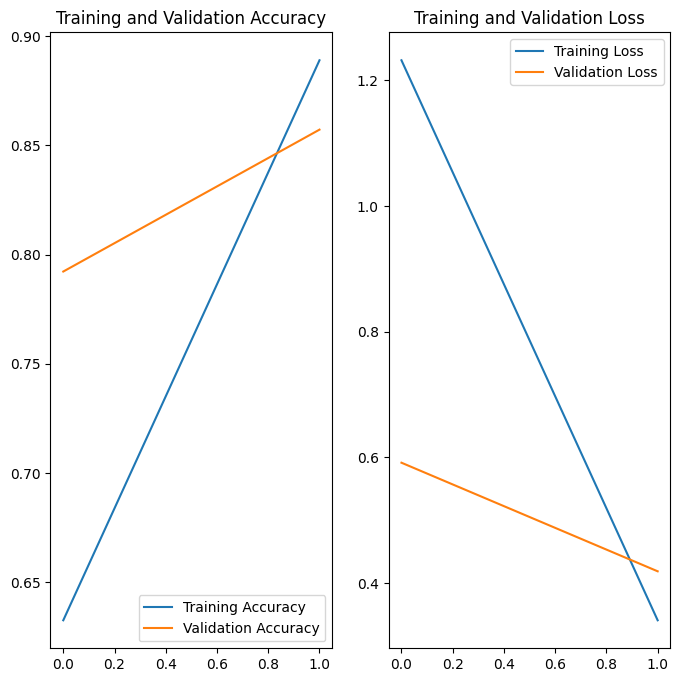

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

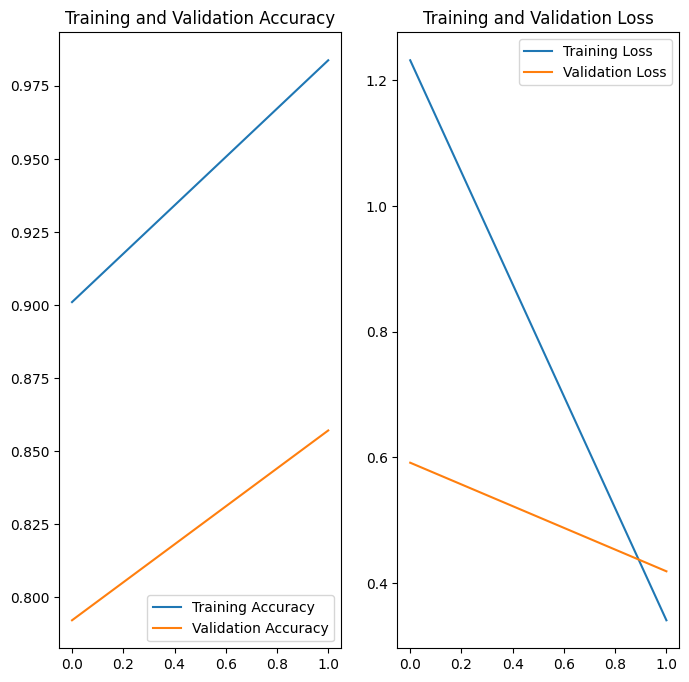

In [17]:
acc = history1.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
#model.save('C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\efficientnet_model.keras')
model.save(path+'\\efficientnet_30_epochs_model.keras')

In [19]:
#path = os.getcwd()
prediction_folder = path + '\\prediction'
folder = prediction_folder + '\\*'
#os.scandir
#from glob import glob
files = glob(folder, recursive = True)
#folder

In [22]:
files = glob(folder, recursive = True)
for image_path in files:
    image = tf.keras.utils.load_img(image_path)
    image = tf.image.resize(image, [img_height, img_width])
    input_arr = tf.keras.utils.img_to_array(image)
    predictions = model.predict(np.array([input_arr]))#(normalized_input_arr)
    print(image_path[image_path.rfind('\\')+1:], ' - ',np.argmax(predictions), '(',detail_names_list[np.argmax(predictions)],')')

1/1 [==============================] - 0s 69ms/step
IMG_20230920_150331 (2).jpg  -  12 ( СК20.01.01.01.406 )
1/1 [==============================] - 0s 86ms/step
IMG_20230920_150331.jpg  -  12 ( СК20.01.01.01.406 )
1/1 [==============================] - 0s 78ms/step
IMG_20230920_150331_1 (2).jpg  -  12 ( СК20.01.01.01.406 )
1/1 [==============================] - 0s 62ms/step
IMG_20230920_150331_1.jpg  -  12 ( СК20.01.01.01.406 )
1/1 [==============================] - 0s 84ms/step
IMG_20230920_150332 (2).jpg  -  12 ( СК20.01.01.01.406 )
1/1 [==============================] - 0s 76ms/step
IMG_20230920_150332.jpg  -  12 ( СК20.01.01.01.406 )
1/1 [==============================] - 0s 71ms/step
IMG_20230920_150333 (2).jpg  -  12 ( СК20.01.01.01.406 )
1/1 [==============================] - 0s 78ms/step
IMG_20230920_150333.jpg  -  12 ( СК20.01.01.01.406 )
1/1 [==============================] - 0s 77ms/step
IMG_20230920_150335 (2).jpg  -  12 ( СК20.01.01.01.406 )
1/1 [==========================